# <center> Delivery Rider Response Challenge by GalsenAI </center>

<img src="https://im0-tub-com.yandex.net/i?id=b4b831d9566e968a5d2651f37af35b93&n=13" width="1024" height="500" align="center"/>

In [1]:
#@title
print("""
Delivery Rider Response Challenge organized by GalsenAI and solved by The Misfits Team/
├── Data
│   ├── Riders.csv
│   ├── SampleSubmission.csv
│   ├── Test.csv
│   └── Train.csv
├── Notebooks
│   └── Final Solution.ipynb
└── Submissions

3 directories, 5 files
""")


Delivery Rider Response Challenge organized by GalsenAI and solved by The Misfits Team/
├── Data
│   ├── Riders.csv
│   ├── SampleSubmission.csv
│   ├── Test.csv
│   └── Train.csv
├── Notebooks
│   └── Final Solution.ipynb
└── Submissions

3 directories, 5 files



# Libraries

In [2]:
# Lets install catboost for creating a model
!pip install -q catboost==0.26.1

     |████████████████████████████████| 67.4 MB 55 kB/s 


In [3]:
import os, warnings
warnings.filterwarnings("ignore") 
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder 
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import mean_squared_error, mean_squared_log_error,log_loss
from sklearn.model_selection import train_test_split,KFold, GroupKFold, StratifiedKFold

# Fitting the data to model
from catboost import CatBoostClassifier

from time import sleep

In [4]:
import numpy, pandas, catboost, sklearn

In [5]:
print("numpy: ", numpy.__version__) #1.19.5
print("pandas: ", pandas.__version__) #1.1.5
print("catboost: ", catboost.__version__) #0.26.1
print("sklearn: ", sklearn.__version__) #0.22.2.post1


numpy:  1.19.5
pandas:  1.1.5
catboost:  0.26.1
sklearn:  0.22.2.post1


# Load Data

In [6]:
os.chdir("/content/drive/MyDrive/ Delivery Rider Response Challenge organized by GalsenAI and solved by The Misfits Team/Data")

In [7]:
# Load the data
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')
df_riders = pd.read_csv('Riders.csv')
df_ss = pd.read_csv('SampleSubmission.csv')

# EDA

In [8]:
# Creating Copy to work with
train = df_train.copy()
test = df_test.copy()
riders = df_riders.copy()

In [9]:
# Determining the no. of records in our datasets
print('The train dataset has ', train.shape[1], ' columns and ', train.shape[0], ' rows!')
print('The test dataset has ', test.shape[1], ' columns and ', test.shape[0], ' rows!')
print('The test dataset has ', riders.shape[1], ' columns and ', riders.shape[0], ' rows!')

The train dataset has  21  columns and  179867  rows!
The test dataset has  20  columns and  76791  rows!
The test dataset has  4  columns and  2632  rows!


In [10]:
# Separate target variable 
target = train['target']

In [11]:
# Drop target column then join Train and test
train.drop('target',axis = 1, inplace = True)

# Merge the train and test dataframe
frames = [train,test]
df = pd.concat(frames)

In [12]:
# Checking unique values and number of rows asigned for each column in the dataset
for i in df.columns:
  
  print('\n')
  
  print(i,df[i].nunique())

  print(i,df[i].unique())



ID 256658
ID ['ID_SCUW21PVAU' 'ID_2HA7X30JMN' 'ID_IAJWDTBY6M' ... 'ID_VDI8L0SWNS'
 'ID_7L22AF1T6K' 'ID_LMMA33Q7YL']


order_id 64326
order_id [ 4435 32711  8712 ... 11467 12867 12617]


dispatch_day 31
dispatch_day [27 30 14 22  3 18 28 20  6 12 17  7  5  1 15 31 16  4 25 19 11 23 21  9
 13 10 26  2  8 29 24]


dispatch_day_of_week 7
dispatch_day_of_week [6 7 2 3 5 4 1]


dispatch_time 5788
dispatch_time ['09:02:54' '13:01:37' '10:01:00' ... '06:09:58' '20:08:49' '05:09:47']


client_id 5457
client_id [ 593630  837729  695129 ...  676936 2533910 2361571]


client_type 2
client_type ['Business' 'Personal']


order_license_status 2
order_license_status [0 1]


order_carrier_type 3
order_carrier_type [2 1 0]


vendor_type 1
vendor_type ['Bike']


rider_id 775
rider_id [ 30153  20884  33143  96531 103546  66125  66033  45701 117622  40066
  74842  93610   9729 117093  80132  93633 117760 115184  62445 118082
  76406   5865 118588 100441   7383 105892  66010 106398 100855  64561
  53521  

## Feature Engineering

##### Rider Amount Class

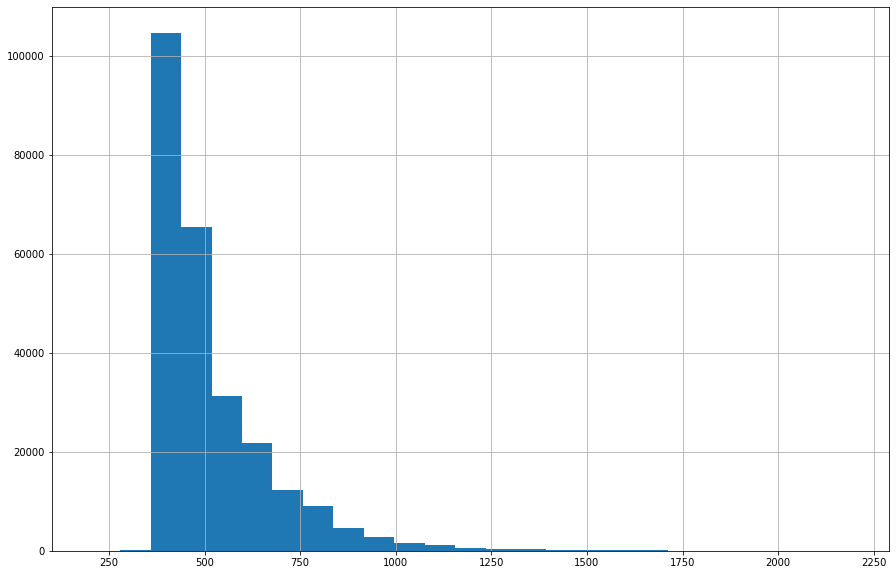

In [13]:
# Let's view the distribution of the rider's payment for the dispatch
hist_amount = df.rider_amount.hist(bins=25,figsize=[15,10])

In [14]:
# create a list of our conditions
conditions = [
    (df['rider_amount'] <= 390),
    (df['rider_amount'] > 390) & (df['rider_amount'] <= 650),
    (df['rider_amount'] > 650) & (df['rider_amount'] <= 820),
    (df['rider_amount'] > 800) & (df['rider_amount'] <= 1200)
    ]

# create a list of the values we want to assign for each condition
values = ['2', '4', '3', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
df['rider_amount_range'] = np.select(conditions, values)

# display updated DataFrame
df.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4


Day of month

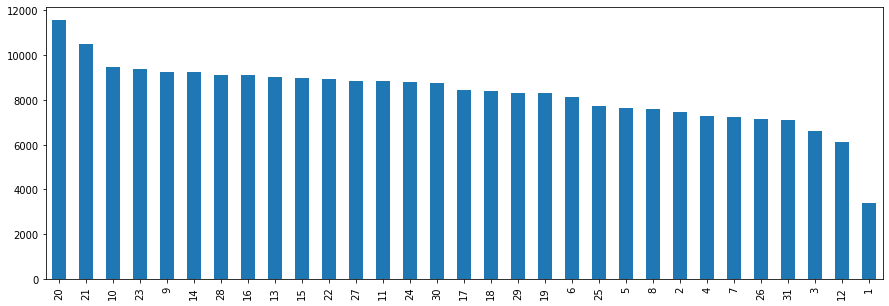

In [15]:
# Dispatches frequency per day of month
df['dispatch_day'].value_counts().plot(kind='bar',figsize=[15,5])

In [16]:
# create a list of our conditions
conditions = [
    (df['dispatch_day'] == 1),
    (df['dispatch_day'] > 1) & (df['dispatch_day'] <= 6),
    (df['dispatch_day'] > 6) & (df['dispatch_day'] <= 8),
    (df['dispatch_day'] >8)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2','3','4']

# create a new column and use np.select to assign values to it using our lists as arguments
df['dispatch_day_range'] = np.select(conditions, values)

# display updated DataFrame
df.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4


Weekends

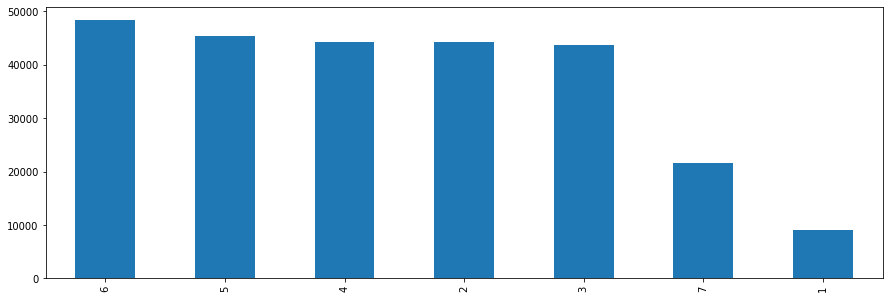

In [17]:
# Dispatches frequency per  weekday
df['dispatch_day_of_week'].value_counts().plot(kind='bar',figsize=[15,5])

In [18]:
# create a list of our conditions
conditions = [
    (df['dispatch_day_of_week'] == 1),
    (df['dispatch_day_of_week'] == 7)
    ]

# create a list of the values we want to assign for each condition
values = ['2', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
df['weekend'] = np.select(conditions, values)

# display updated DataFrame
df.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4,0


Busy Hours

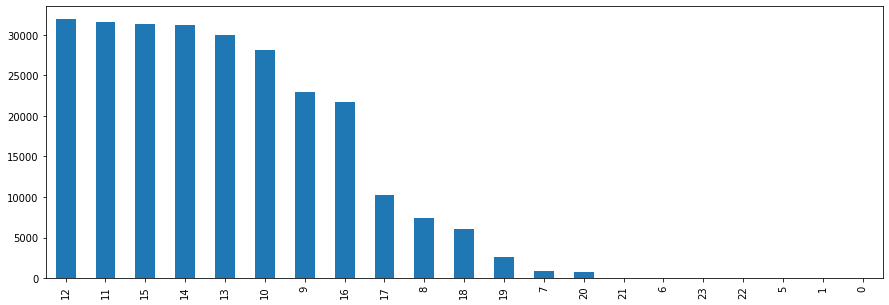

In [19]:
# Convert time column to datetime
df['dispatch_time'] = pd.to_datetime(df['dispatch_time'])

# Extract Hour Column
df['dispatch_hour'] = df['dispatch_time'].dt.hour

# Let's view the hourly distribution of dispatches
df['dispatch_hour'].value_counts().plot(kind='bar',figsize=[15,5])

In [20]:
# Let's get the cos and cosine of our Time Variable
time_column = ["dispatch_time"]

for col in time_column:
  df[col.split('_')[0] + '_hour_sine'] = np.sin(2 * np.pi * df[col].dt.hour/24)
  df[col.split('_')[0] + '_hour_cos'] = np.cos(2* np.pi * df[col].dt.hour/24)

In [21]:
# create a list of our conditions
conditions = [
    (df['dispatch_hour'] <= 6),
    (df['dispatch_hour'] > 8) & (df['dispatch_hour'] <= 16),
    (df['dispatch_hour'] > 16) & (df['dispatch_hour'] <= 20),
    (df['dispatch_hour'] > 20)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '4', '3', '2']

# create a new column and use np.select to assign values to it using our lists as arguments
df['busy_hours'] = np.select(conditions, values)

# display updated DataFrame
df.head(2)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours
0,ID_SCUW21PVAU,4435,27,6,2021-09-07 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4
1,ID_2HA7X30JMN,32711,30,7,2021-09-07 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4


In [22]:
def bearing(lat1, lng1, lat2, lng2):
    lon_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    return np.degrees(np.arctan2(np.sin(lon_rad) * np.cos(lat2), np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_rad)))

#Features Interaction:

In [23]:
# create combination feature
df['rider_dispatch_ft'] = df['rider_id'].astype(str) + '-' + df['dispatch_hour'].astype(str)

df['bearing_Rider_PickUp'] = bearing(df['rider_lat'], df['rider_long'], df['pickup_lat'], df['pickup_long'])

# create agg per order_id 
distance_statistics = df.groupby(by="order_id",as_index=False).agg({'bearing_Rider_PickUp':['mean','min','max','std'],})
distance_statistics.columns = ["_By_OrderId_".join(x) for x in distance_statistics.columns.ravel()]
df = pd.merge(df,distance_statistics,how="left",right_on="order_id_By_OrderId_",left_on="order_id")
del df['order_id_By_OrderId_']

**Label encode "rider_dispatch_ft" feature:**

In [24]:
LE = LabelEncoder()
LE_features = ['rider_dispatch_ft']               
for feature in LE_features :
  df[feature] = LE.fit_transform(df[feature].astype(str))

Geo Distance

In [25]:
# Calculate distance between coordinates

def distance_calc(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    AVG_EARTH_RADIUS = 6371  # in km
    
    lat = lat2 - lat1
    
    lng = lng2 - lng1
    
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    
    return h

In [26]:
# Let's create variables for the distances between the locations of the riders, pickup points and dropoff points
df['rider_dropoff_dist'] = distance_calc(df.rider_lat, df.rider_long, df.drop_off_lat, df.drop_off_long)
df['rider_pickup_dist'] = distance_calc(df.rider_lat, df.rider_long, df.pickup_lat, df.pickup_long)
df['pickup_dropoff_dist'] = distance_calc(df.pickup_lat, df.pickup_long, df.drop_off_lat, df.drop_off_long)


### Distance Ranges

Pickup Drop_off ranges

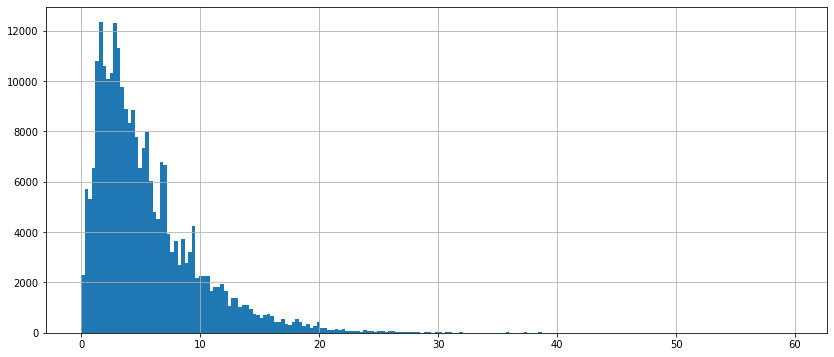

In [27]:
# We can now view the distribution of the distance between pickup and drop off locations

bin_values = np.arange(start=-0, stop=60, step=0.3)
df['pickup_dropoff_dist'].hist(bins=bin_values, figsize=[14,6])

In [28]:
# create a list of our conditions
conditions = [
    (df['pickup_dropoff_dist'] <= 6),
    (df['pickup_dropoff_dist'] > 6) & (df['pickup_dropoff_dist'] <= 16),
    (df['pickup_dropoff_dist'] > 16) & (df['pickup_dropoff_dist'] <= 30),
    (df['pickup_dropoff_dist'] > 30) & (df['pickup_dropoff_dist'] <= 50),
    (df['pickup_dropoff_dist'] > 50)
    ]

# create a list of the values we want to assign for each condition
values = ['5','4', '3', '2', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
df['pickup_dropoff_dist_range'] = np.select(conditions, values)

# display updated DataFrame
df.head(2)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours,rider_dispatch_ft,bearing_Rider_PickUp,bearing_Rider_PickUp_By_OrderId_mean,bearing_Rider_PickUp_By_OrderId_min,bearing_Rider_PickUp_By_OrderId_max,bearing_Rider_PickUp_By_OrderId_std,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range
0,ID_SCUW21PVAU,4435,27,6,2021-09-07 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4,3076,-67.659597,-52.037239,-70.030817,-18.421302,29.136388,16.076117,1.746491,14.426076,4
1,ID_2HA7X30JMN,32711,30,7,2021-09-07 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4,2743,-22.752722,-22.752722,-22.752722,-22.752722,NaN,13.417651,0.394373,13.126454,4


Rider_Pickup_Ranges

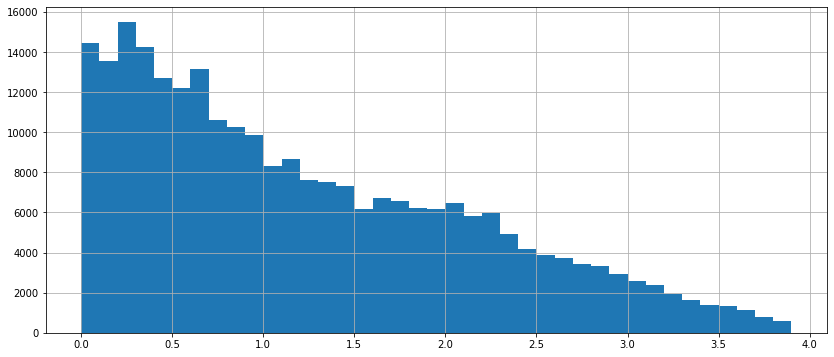

In [29]:
# Let's also look at distribution of the distance between the rider and the pickup location

bin_values = np.arange(start=-0, stop=4, step=0.1)
df['rider_pickup_dist'].hist(bins=bin_values, figsize=[14,6])

In [30]:
# create a list of our conditions
conditions = [
    (df['rider_pickup_dist'] <= 1),
    (df['rider_pickup_dist'] > 1) & (df['rider_pickup_dist'] <= 1.5),
    (df['rider_pickup_dist'] > 1.5) & (df['rider_pickup_dist'] <= 2.5),
    (df['rider_pickup_dist'] > 2.5) & (df['rider_pickup_dist'] <= 3.7),
    (df['rider_pickup_dist'] > 3.7)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','5']

# create a new column and use np.select to assign values to it using our lists as arguments
df['rider_pickup_dist_range'] = np.select(conditions, values)

# display updated DataFrame
df.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours,rider_dispatch_ft,bearing_Rider_PickUp,bearing_Rider_PickUp_By_OrderId_mean,bearing_Rider_PickUp_By_OrderId_min,bearing_Rider_PickUp_By_OrderId_max,bearing_Rider_PickUp_By_OrderId_std,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range
0,ID_SCUW21PVAU,4435,27,6,2021-09-07 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4,3076,-67.659597,-52.037239,-70.030817,-18.421302,29.136388,16.076117,1.746491,14.426076,4,3
1,ID_2HA7X30JMN,32711,30,7,2021-09-07 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4,2743,-22.752722,-22.752722,-22.752722,-22.752722,NaN,13.417651,0.394373,13.126454,4,1
2,ID_IAJWDTBY6M,8712,14,2,2021-09-07 10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4,0,10,0.500000,-0.866025,4,3163,-164.786368,-19.722334,-164.786368,165.004835,110.149486,7.224872,1.846564,5.421337,5,3


Rider Drop_off_Ranges

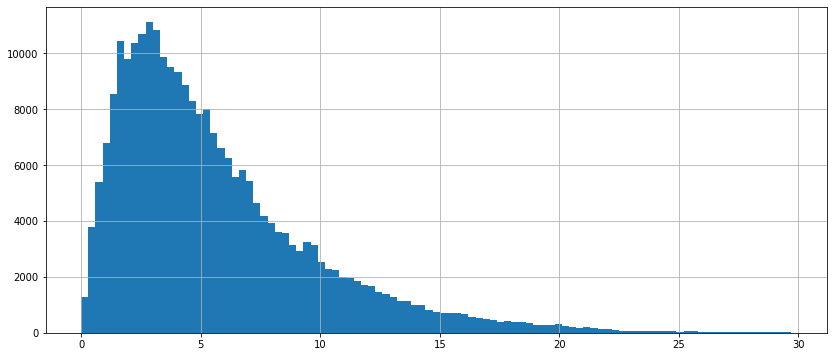

In [31]:
# Let's also visualize the distance between the rider and drop off location

bin_values = np.arange(start=-0, stop=30, step=0.3)
df['rider_dropoff_dist'].hist(bins=bin_values, figsize=[14,6])

In [32]:
# create a list of our conditions
conditions = [
    (df['rider_dropoff_dist'] <= 5),
    (df['rider_dropoff_dist'] > 5) & (df['rider_dropoff_dist'] <= 10),
    (df['rider_dropoff_dist'] > 10) & (df['rider_dropoff_dist'] <= 18),
    (df['rider_dropoff_dist'] > 18) & (df['rider_dropoff_dist'] <= 30),
    (df['rider_dropoff_dist'] > 30)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','5']

# create a new column and use np.select to assign values to it using our lists as arguments
df['rider_dropoff_dist_range'] = np.select(conditions, values)

# display updated DataFrame
df.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours,rider_dispatch_ft,bearing_Rider_PickUp,bearing_Rider_PickUp_By_OrderId_mean,bearing_Rider_PickUp_By_OrderId_min,bearing_Rider_PickUp_By_OrderId_max,bearing_Rider_PickUp_By_OrderId_std,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range,rider_dropoff_dist_range
0,ID_SCUW21PVAU,4435,27,6,2021-09-07 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4,3076,-67.659597,-52.037239,-70.030817,-18.421302,29.136388,16.076117,1.746491,14.426076,4,3,3
1,ID_2HA7X30JMN,32711,30,7,2021-09-07 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4,2743,-22.752722,-22.752722,-22.752722,-22.752722,NaN,13.417651,0.394373,13.126454,4,1,3
2,ID_IAJWDTBY6M,8712,14,2,2021-09-07 10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4,0,10,0.500000,-0.866025,4,3163,-164.786368,-19.722334,-164.786368,165.004835,110.149486,7.224872,1.846564,5.421337,5,3,2


Time and Distance

In [33]:
# create a list of our conditions
conditions = [
    (df['rider_dropoff_dist_range'] == '5') & (df['busy_hours'] == '1'),
    (df['rider_dropoff_dist_range'] == '4') & (df['busy_hours'] == '2'),
    (df['rider_dropoff_dist_range'] == '3') & (df['busy_hours'] == '3'),
    (df['rider_dropoff_dist_range'] == '2') & (df['busy_hours'] == '4'),
    (df['rider_dropoff_dist_range'] == '1') & (df['busy_hours'] == '4'),
    (df['rider_dropoff_dist_range'] == '2') & (df['busy_hours'] == '0')
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','6','5']

# create a new column and use np.select to assign values to it using our lists as arguments
df['time_distance_bias'] = np.select(conditions, values)

# display updated DataFrame
df.head(2)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours,rider_dispatch_ft,bearing_Rider_PickUp,bearing_Rider_PickUp_By_OrderId_mean,bearing_Rider_PickUp_By_OrderId_min,bearing_Rider_PickUp_By_OrderId_max,bearing_Rider_PickUp_By_OrderId_std,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range,rider_dropoff_dist_range,time_distance_bias
0,ID_SCUW21PVAU,4435,27,6,2021-09-07 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4,3076,-67.659597,-52.037239,-70.030817,-18.421302,29.136388,16.076117,1.746491,14.426076,4,3,3,0
1,ID_2HA7X30JMN,32711,30,7,2021-09-07 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4,2743,-22.752722,-22.752722,-22.752722,-22.752722,NaN,13.417651,0.394373,13.126454,4,1,3,0


Weekday vs Time_distance

In [34]:
# create a list of our conditions
conditions = [
    (df['dispatch_day_of_week'] == '1') & (df['time_distance_bias'] == '5'), # Sunday  early morning & average distance
    (df['dispatch_day_of_week'] == '7') & (df['time_distance_bias'] == '3'), # Saturday late night & long distance
    (df['dispatch_day_of_week'] == '7') & (df['time_distance_bias'] == '5'), # Saturday early morning average distance
    (df['dispatch_day_of_week'] == '0') & (df['time_distance_bias'] == '3'), # Weekday late night & long distance
    (df['dispatch_day_of_week'] == '0') & (df['time_distance_bias'] == '6')  # Weekday daytime and average distance
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','5']

# create a new column and use np.select to assign values to it using our lists as arguments
df['weekend_time_distance_bias'] = np.select(conditions, values)

# display updated DataFrame
df.head(2)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours,rider_dispatch_ft,bearing_Rider_PickUp,bearing_Rider_PickUp_By_OrderId_mean,bearing_Rider_PickUp_By_OrderId_min,bearing_Rider_PickUp_By_OrderId_max,bearing_Rider_PickUp_By_OrderId_std,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range,rider_dropoff_dist_range,time_distance_bias,weekend_time_distance_bias
0,ID_SCUW21PVAU,4435,27,6,2021-09-07 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4,3076,-67.659597,-52.037239,-70.030817,-18.421302,29.136388,16.076117,1.746491,14.426076,4,3,3,0,0
1,ID_2HA7X30JMN,32711,30,7,2021-09-07 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4,2743,-22.752722,-22.752722,-22.752722,-22.752722,NaN,13.417651,0.394373,13.126454,4,1,3,0,0


Money Earned VS time & Distance

In [35]:
# create a list of our conditions
conditions = [
    (df['rider_amount_range'] == '4') & (df['busy_hours'] == '4'),
    (df['rider_pickup_dist_range'] == '3') & (df['busy_hours'] == '2'),
    (df['rider_pickup_dist_range'] == '1') & (df['rider_amount_range'] == '4'),
    (df['rider_pickup_dist_range'] == '4') & (df['rider_amount_range'] == '4')
    ]

# create a list of the values we want to assign for each condition
values = ['4','2','6','1']

# create a new column and use np.select to assign values to it using our lists as arguments
df['money_distance_bias'] = np.select(conditions, values)

# display updated DataFrame
df.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours,rider_dispatch_ft,bearing_Rider_PickUp,bearing_Rider_PickUp_By_OrderId_mean,bearing_Rider_PickUp_By_OrderId_min,bearing_Rider_PickUp_By_OrderId_max,bearing_Rider_PickUp_By_OrderId_std,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range,rider_dropoff_dist_range,time_distance_bias,weekend_time_distance_bias,money_distance_bias
0,ID_SCUW21PVAU,4435,27,6,2021-09-07 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4,3076,-67.659597,-52.037239,-70.030817,-18.421302,29.136388,16.076117,1.746491,14.426076,4,3,3,0,0,0
1,ID_2HA7X30JMN,32711,30,7,2021-09-07 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4,2743,-22.752722,-22.752722,-22.752722,-22.752722,NaN,13.417651,0.394373,13.126454,4,1,3,0,0,0
2,ID_IAJWDTBY6M,8712,14,2,2021-09-07 10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4,0,10,0.500000,-0.866025,4,3163,-164.786368,-19.722334,-164.786368,165.004835,110.149486,7.224872,1.846564,5.421337,5,3,2,4,0,4


Correcting Dtypes

In [36]:
# let's convert some string columns to numeric
df[['rider_dropoff_dist_range',	'time_distance_bias',	'weekend_time_distance_bias','busy_hours','weekend','money_distance_bias']] = df[['rider_dropoff_dist_range',	'time_distance_bias',	'weekend_time_distance_bias','busy_hours','weekend','money_distance_bias']].apply(pd.to_numeric)

## Modelling:

#CatBoostClassifier (without KFolds)

In [37]:
# Split train and test set
train = df.iloc[:179867, :]
test = df.iloc[179867:, :]

In [38]:
# Selecting the columns to be used as data for accuracy testing
cols = [col for col in train.columns if col not in ['dispatch_time', 'ID']]

# Set the target and independent variables
X = train[cols]
y = target
test=test[cols]

In [39]:
km = KMeans(n_clusters=7)

In [40]:
def encoder(train, test):
  le = LabelEncoder()
  for col in train.select_dtypes("object").columns:
    train[col]=le.fit_transform(train[col])
    test[col]=le.transform(test[col])
  return train, test

In [41]:
X_enc, test_enc = encoder(X, test)

In [42]:
X_enc.isna().sum()[X_enc.isna().sum()!=0]

bearing_Rider_PickUp_By_OrderId_std    8423
dtype: int64

In [43]:
X_enc.fillna(X_enc.mean(), inplace=True)

In [44]:
test_enc.fillna(test_enc.mean(), inplace=True)

In [45]:
X["cluster"]=km.fit_predict(X_enc)
test["cluster"]=km.predict(test_enc)

In [46]:
X.bearing_Rider_PickUp_By_OrderId_std.fillna(X.bearing_Rider_PickUp_By_OrderId_std.mean(), inplace=True)
test.bearing_Rider_PickUp_By_OrderId_std.fillna(test.bearing_Rider_PickUp_By_OrderId_std.mean(), inplace=True)

In [47]:
try:
  test.drop(['dispatch_time', 'ID'],axis = 1, inplace=True)
except:
  pass

In [48]:
skf = StratifiedKFold(5,True, 34)

In [50]:
# class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)
# class_weights

In [51]:
# You can increase the iterations parameter but it will take longer to learn
model = CatBoostClassifier(iterations = 1000, early_stopping_rounds = 50, task_type="CPU",# random_state=42,# learning_rate=0.103116,
                          #  class_weights=class_weights
                           )


In [52]:
# Here we fit our data then make predictions

# Since Catboost accepts categorical features we'll make then identifiable to the model 
categorical_features_indices = np.where(X.dtypes != np.float)[0]

# Fitting our data to the model
model.fit(X,y,cat_features=categorical_features_indices)

# Making Predictions
y_pred = model.predict(test)
model.score(X,y)

Learning rate set to 0.103116
0:	learn: 1.0501502	total: 2.62s	remaining: 43m 39s
1:	learn: 1.0127189	total: 5.5s	remaining: 45m 45s
2:	learn: 0.9834964	total: 8.23s	remaining: 45m 35s
3:	learn: 0.9595154	total: 10.8s	remaining: 44m 43s
4:	learn: 0.9383601	total: 13s	remaining: 43m 7s
5:	learn: 0.9164166	total: 15.1s	remaining: 41m 41s
6:	learn: 0.8974162	total: 17.6s	remaining: 41m 34s
7:	learn: 0.8819725	total: 19.9s	remaining: 41m 13s
8:	learn: 0.8690999	total: 22.4s	remaining: 41m 9s
9:	learn: 0.8534219	total: 25s	remaining: 41m 18s
10:	learn: 0.8403414	total: 27.5s	remaining: 41m 16s
11:	learn: 0.8293568	total: 30.3s	remaining: 41m 33s
12:	learn: 0.8189377	total: 33s	remaining: 41m 46s
13:	learn: 0.8098480	total: 35.8s	remaining: 42m
14:	learn: 0.8022991	total: 38.3s	remaining: 41m 55s
15:	learn: 0.7963116	total: 41s	remaining: 42m 2s
16:	learn: 0.7901495	total: 43.5s	remaining: 41m 54s
17:	learn: 0.7810011	total: 46s	remaining: 41m 48s
18:	learn: 0.7743444	total: 48.5s	remaining:

0.043660037694518726

In [53]:
# Let's create a submission file to input our predictions
submissionFile= pd.DataFrame({"ID":df_test["ID"]})
submissionFile['target'] = y_pred


In [54]:
# Saving our data in a CSV
model_name = "submit"
submissionFile.to_csv(f"../Submissions/{model_name}.csv",index=False)            # 0.74080 on LB

In [55]:
submissionFile['target'].value_counts()

0    43687
2    19285
1    13819
Name: target, dtype: int64

In [56]:
from google.colab import files
files.download(f"../Submissions/{model_name}.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>